# 14. REINFORCE (Monte Carlo Policy Gradient)

지금까지 배운 Q-Learning이나 SARSA는 가치 함수(Value Function, Q)를 먼저 학습하고, 그 Q값을 토대로 행동을 선택하는 **가치 기반(Value-based)** 방법이었다.

반면 **REINFORCE**는 가치 함수를 거치지 않고, 상태 를 입력받아 행동 확률 $\pi(a|s)$를 직접 출력하는 **정책 신경망(Policy Network)**을 학습시킨다.

핵심 아이디어는 다음과 같다.

* 어떤 행동을 해서 좋은 결과(높은 반환값, )를 얻었다면, 그 행동을 할 확률을 높인다.
* 나쁜 결과를 얻었다면, 그 행동을 할 확률을 낮춘다.

이때 업데이트 식은 다음과 같다.


### 0. 라이브러리 설정

최신 버전인 `gymnasium`과 `torch`를 불러온다. 병렬 처리를 위해 CPU 코어 수도 확인한다.

In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## 1. 환경 설정 및 전처리

이번에도 **CartPole-v1** 환경을 사용한다.
정책 경사 방법은 데이터 수집 속도가 중요하므로, 여러 개의 환경을 동시에 실행(Parallel Environments)하여 데이터를 모으는 것이 일반적이다. 하지만 여기서는 이해를 돕기 위해 **단일 환경**에서 에피소드를 수집하는 기본 구조로 구현한다.

PyTorch 모델에 입력하기 위해 전처리 래퍼를 정의한다.

In [19]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        # 텐서 변환 및 배치 차원 추가
        return torch.from_numpy(obs).float().unsqueeze(0).to(device), info

    def step(self, action):
        action_item = action.item()
        next_obs, reward, terminated, truncated, info = self.env.step(action_item)
        next_obs = torch.from_numpy(next_obs).float().unsqueeze(0).to(device)
        done = terminated or truncated
        return next_obs, reward, done, truncated, info

# 환경 생성
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = PreprocessEnv(env)

state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n

print(f"State dimensions: {state_dims}, Actions: {num_actions}")

State dimensions: 4, Actions: 2


---

## 2. 정책 네트워크 (Policy Network)

상태를 입력받아 각 행동을 선택할 **확률(Probability)**을 출력한다. 확률 분포를 출력해야 하므로 마지막 활성화 함수로 **Softmax**를 사용한다.

In [20]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

policy_net = PolicyNetwork(state_dims, num_actions).to(device)
print(policy_net)

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)


### 2.1 초기 정책 시각화

학습되지 않은 정책이 특정 상태에서 어떤 확률 분포를 보이는지 확인해 본다.

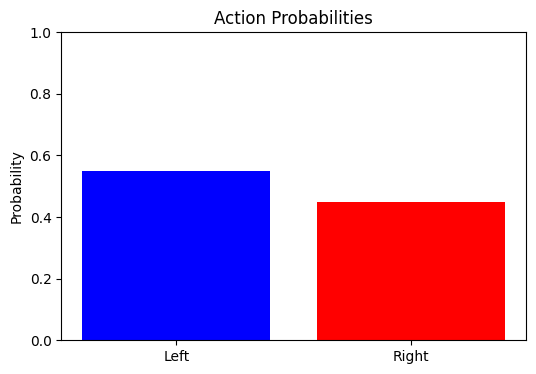

In [21]:
def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color=['blue', 'red'])
    plt.ylabel("Probability")
    plt.title("Action Probabilities")
    plt.ylim(0, 1)
    plt.show()

# 테스트용 상태: 카트가 중간에 정지해 있을 때
neutral_state = torch.zeros(1, 4).to(device)
with torch.no_grad():
    probs = policy_net(neutral_state).cpu().numpy()[0]

plot_action_probs(probs, labels=['Left', 'Right'])

---

## 3. REINFORCE 알고리즘 구현

REINFORCE는 **몬테카를로(Monte Carlo)** 방식이므로, 에피소드가 끝날 때까지 기다렸다가 전체 데이터를 이용해 학습한다.

1. 에피소드를 진행하며 `(상태, 행동 로그 확률, 보상)`을 저장한다.
2. 에피소드가 끝나면 뒤에서부터 반환값 를 계산한다.
3. 손실 함수  를 계산하고 역전파한다. (경사 상승법을 위해 마이너스를 붙임)

In [22]:
def reinforce(policy_net, episodes, alpha=0.001, gamma=0.99):
    optimizer = optim.AdamW(policy_net.parameters(), lr=alpha)
    stats = {'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state, _ = env.reset()
        done = False

        # 에피소드 동안의 데이터를 저장할 리스트
        log_probs = []
        rewards = []

        # 1. 에피소드 생성 (Generate an episode)
        while not done:
            # 정책 신경망에서 행동 확률 출력
            probs = policy_net(state)

            # 확률 분포에 따라 행동 샘플링 (Categorical 분포 사용)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            # 선택한 행동의 로그 확률 저장 (나중에 미분할 대상)
            log_prob = dist.log_prob(action)
            log_probs.append(log_prob)

            # 환경 상호작용
            next_state, reward, done, truncated, _ = env.step(action)

            rewards.append(reward)
            state = next_state

            # (CartPole-v1은 최대 500 스텝)

        stats['Returns'].append(sum(rewards))

        # 2. 반환값 G_t 계산 (Calculate Returns)
        # 뒤에서부터 계산하여 할인율 적용: G_t = R_{t+1} + gamma * G_{t+1}
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        # 텐서로 변환
        returns = torch.tensor(returns, device=device)

        # (선택사항) 반환값 정규화: 학습 안정성을 높임
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # 3. 정책 경사 업데이트 (Update Policy)
        policy_loss = []
        for log_prob, G_t in zip(log_probs, returns):
            # Loss = - log(prob) * Return
            # Return이 클수록 해당 log_prob를 높이는 방향(Loss 감소)으로 업데이트됨
            policy_loss.append(-log_prob * G_t)

        # 모든 스텝의 손실을 합쳐서 역전파
        optimizer.zero_grad()
        # sum()을 사용하여 배치 업데이트 효과
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        optimizer.step()

    return stats

---

## 4. 학습 실행

REINFORCE 에이전트를 학습시킨다. 정책 경사 방법은 수렴이 다소 불안정할 수 있으나, CartPole과 같은 간단한 환경에서는 비교적 잘 작동한다.

In [23]:
print("REINFORCE 학습 시작...")
# 500 에피소드 정도면 CartPole-v1을 어느 정도 학습함
stats = reinforce(policy_net, episodes=500, alpha=0.001)
print("학습 완료!")

REINFORCE 학습 시작...


100%|██████████| 500/500 [03:23<00:00,  2.45it/s]

학습 완료!


### 4.1 학습 결과 시각화

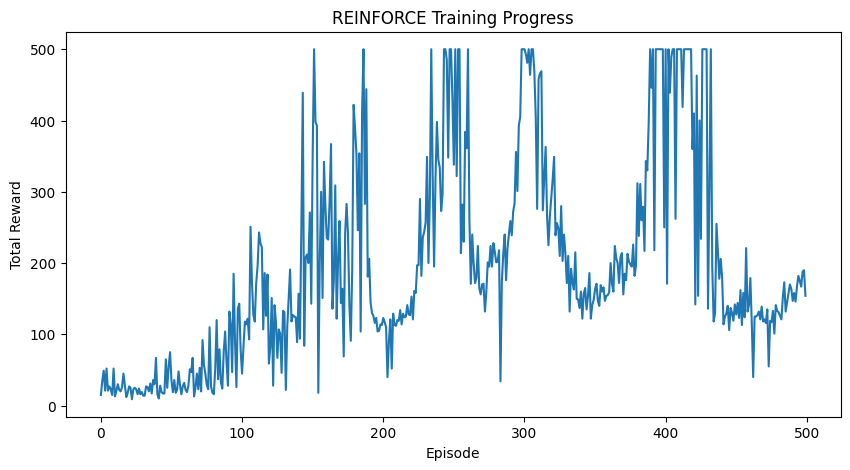

In [24]:
def plot_stats(stats):
    plt.figure(figsize=(10, 5))
    plt.plot(stats['Returns'])
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("REINFORCE Training Progress")
    plt.show()

plot_stats(stats)

### 4.2 학습된 정책 확인

학습 후 특정 상황에서 에이전트가 어떤 판단을 내리는지 확률 분포로 확인한다.

* **왼쪽 위험 상황:** 카트가 왼쪽으로 치우치면 오른쪽으로 갈 확률이 높아야 한다.
* **오른쪽 위험 상황:** 카트가 오른쪽으로 치우치면 왼쪽으로 갈 확률이 높아야 한다.

왼쪽 위험 상황에서의 행동 확률:


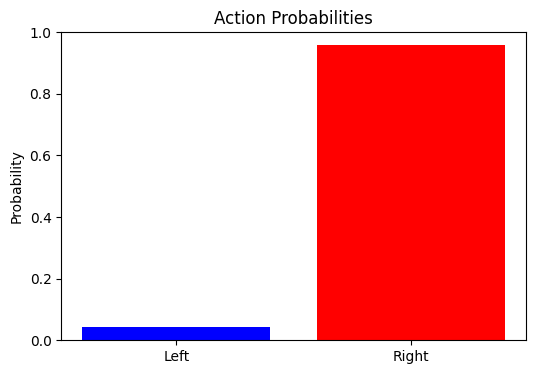

오른쪽 위험 상황에서의 행동 확률:


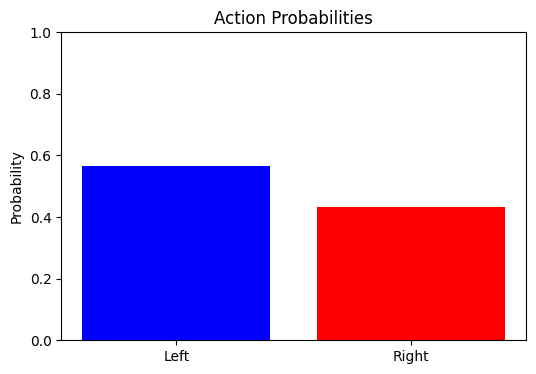

In [25]:
# 상태 정의: [위치, 속도, 각도, 각속도]
left_danger = torch.tensor([[-2.0, 0., 0., 0.]]).to(device)  # 왼쪽 끝
right_danger = torch.tensor([[2.0, 0., 0., 0.]]).to(device)   # 오른쪽 끝

print("왼쪽 위험 상황에서의 행동 확률:")
with torch.no_grad():
    probs_left = policy_net(left_danger).cpu().numpy()[0]
plot_action_probs(probs_left, ['Left', 'Right'])

print("오른쪽 위험 상황에서의 행동 확률:")
with torch.no_grad():
    probs_right = policy_net(right_danger).cpu().numpy()[0]
plot_action_probs(probs_right, ['Left', 'Right'])

### 4.3 에이전트 테스트

Episode 3 finished in 172 steps.


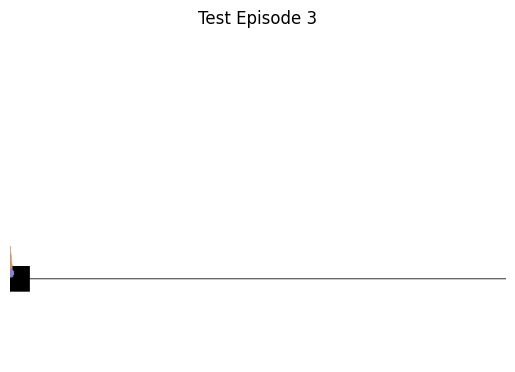

In [26]:
from IPython import display

def test_agent(env, policy_net, episodes=3):
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        step = 0

        img = plt.imshow(env.render())
        plt.axis('off')
        plt.title(f"Test Episode {ep+1}")

        while not done:
            # 확률 기반 행동 선택 (혹은 테스트시는 argmax 사용 가능)
            with torch.no_grad():
                probs = policy_net(state)
                action = torch.argmax(probs, dim=-1) # Greedy

            state, reward, done, truncated, _ = env.step(action)
            #state = torch.from_numpy(state).float().unsqueeze(0).to(device)

            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)
            step += 1

        print(f"Episode {ep+1} finished in {step} steps.")

test_agent(env, policy_net, episodes=3)
env.close()

### 요약

REINFORCE는 가치 함수를 추정하는 대신, 목표(높은 보상)를 달성하는 행동의 확률을 직접 높이는 방식으로 학습한다. 이는 연속적인 행동 공간이나 확률적인 정책이 필요한 문제에 매우 유용하지만, 몬테카를로 방식 특유의 높은 분산(Variance)으로 인해 학습 속도가 느리고 불안정할 수 있다는 단점이 있다. 이를 개선한 것이 **Actor-Critic** 알고리즘이다.